In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

%matplotlib inline

In [23]:
data = pd.read_excel('tim_data/tim_all_cofactors.xlsx')
data = data.assign(Done=[False for i in range(len(data))])
data.head()

,name,element_id,ecocyc_id,plot_id,count,parent,done,Done
0,FE,FE,NaN,10001,483709,-1,False,False
1,Electron Transfer Chains,FE,Electron-Transfer,10104,116919,10001,False,False
2,Amino Acid Biosynthesis,FE,Amino-Acid-Biosynthesis,10109,38957,10001,False,False
3,TCA cycle,FE,TCA-VARIANTS,10103,35260,10001,False,False
4,Regulation of transcription,FE,Regulation of transcription,10113,33935,10001,False,False


In [24]:
def sunburst(nodes, total=np.pi * 2, offset=0, level=0, ax=None):
    ax = ax or plt.subplot(111, projection='polar')

    if level == 0 and len(nodes) == 1:
        label, value, subnodes = nodes[0]
        ax.bar([0], [0.5], [np.pi * 2])
        ax.text(0, 0, label, ha='center', va='center')
        sunburst(subnodes, total=value, level=level + 1, ax=ax)
    elif nodes:
        d = np.pi * 2 / total
        labels, widths, colors = [], [], []
        random_color = list(mcolors.TABLEAU_COLORS)[np.random.randint(0, len(mcolors.TABLEAU_COLORS))]
        local_offset = offset
        for label, value, subnodes in nodes:
            # labels.append(label)
            widths.append(value * d)
            colors.append(random_color) if label != '' else colors.append('black')
            sunburst(subnodes, total=total, offset=local_offset,
                     level=level + 1, ax=ax)
            local_offset += value
        values = np.cumsum([offset * d] + widths[:-1])
        heights = [1] * len(nodes)
        bottoms = np.zeros(len(nodes)) + level - 0.5
        rects = ax.bar(values, heights, widths, bottoms, linewidth=1,
                       edgecolor='white', align='edge', color=colors)
        for rect, label in zip(rects, labels):
            x = rect.get_x() + rect.get_width() / 2
            y = rect.get_y() + rect.get_height() / 2
            rotation = (90 + (360 - np.degrees(x) % 180)) % 360
            ax.text(x, y, label, rotation=rotation, ha='center', va='center') 

    if level == 0:
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location('N')
        ax.set_axis_off()
        
        plt.savefig('tim_data/all_sunburst.png', bbox_inches='tight')

In [25]:
parent_layer_sums = {}
parent_list = data['parent'].unique().tolist()
# layer_list = data['Layer'].unique().tolist()
# max_layer = max(layer_list)

for parent in parent_list:
#    for layer in layer_list:
    cur_sum = 0
    for index, row in data.iterrows():
        if row['parent'] == parent: #and index != len(data) - 1:
            cur_sum += row['count']
    parent_layer_sums[parent] = cur_sum
        
print(parent_layer_sums)

{-1: 960883, 10001: 367831, 10104: 116919, 10109: 38957, 10103: 35260, 10113: 33935, 10106: 79336, 10102: 9919, 10116: 19160, 10108: 11929, 10114: 2348, 10107: 7921, 10105: 2399, 10115: 2383, 10117: 3466, 10112: 1934, 10110: 975, 10111: 990, 20001: 321084, 20125: 75809, 20103: 28023, 20106: 19777, 20124: 23753, 20107: 23385, 20113: 12363, 20123: 20544, 20116: 15298, 20104: 21137, 20110: 11982, 20111: 23473, 20105: 4804, 20117: 3064, 20118: 3064, 20108: 5932, 20126: 3502, 20121: 4289, 20129: 3060, 20128: 9312, 20112: 1087, 20115: 1071, 20114: 1027, 20127: 1295, 20109: 1644, 20102: 615, 20119: 1099, 20120: 415, 20122: 260, 30001: 81990, 30119: 47516, 30104: 8985, 30107: 6221, 30112: 5006, 30122: 7534, 30120: 3212, 30114: 2114, 30106: 471, 30117: 366, 30108: 113, 30109: 83, 30115: 79, 30123: 67, 30110: 60, 30113: 146, 30116: 17, 30103: 0, 30105: 0, 30111: 0, 30102: 0, 30118: 0, 30121: 0, 40001: 21000, 40106: 11804, 40130: 8909, 40127: 260, 40124: 27, 40117: 0, 40104: 0, 40107: 0, 40108: 0

### Version that uses percentages (deprecated)

In [26]:
def transform_data_percent(df, data_tuple, parent_name, parent_value, cur_layer):
    df['Done'] = df['Done'].astype(bool)
    children = df[(df['Layer'] == cur_layer) & (df['Parent'] == parent_name) & (df['Done'] == False)]
    print(children)
    for _, child in children.iterrows():
        child_value = 0
        if parent_layer_sums[(parent_name, cur_layer)] != 0:
            child_value = child['Count'] / parent_layer_sums[(parent_name, cur_layer)] * parent_value
        child_tuple = (child['Name'], child_value, [])
        data_tuple[2].append(child_tuple)
        df.at[child.name, 'Done'] = True  # Mark as done
        transform_data_percent(df, child_tuple, child['Name'], child_value, cur_layer + 1)

## Version that uses actual count values


In [27]:
# def layer_fill(df, data_tuple, cur_layer, parent_value):
#     child_tuple = ('', parent_value, [])
#     data_tuple[2].append(child_tuple)  
#     if cur_layer != max_layer:
#         layer_fill(df, child_tuple, cur_layer + 1, parent_value)

def transform_data_count(df, data_tuple, parent_id, parent_value):
    print(data_tuple)
    df['done'] = df['done'].astype(bool)
    children = df[(df['parent'] == parent_id) & (df['done'] == False)]
    layer_sum = 0
    for _, child in children.iterrows():
        child_value = child['count']
        layer_sum += child_value
        child_tuple = (child['name'], child_value, [])
        data_tuple[2].append(child_tuple)
        df.at[child.name, 'Done'] = True  # Mark as done
        transform_data_count(df, child_tuple, child['plot_id'], child_value)

    if layer_sum != parent_value and len(data_tuple[2]) != 0:
        child_tuple = ('', parent_value - layer_sum, [])
        data_tuple[2].append(child_tuple)
        
        # if cur_layer != max_layer:
            # layer_fill(df, child_tuple, cur_layer + 1, parent_value - layer_sum)

root_value = parent_layer_sums[-1]
data_transformed = [('Root', root_value, [])]
transform_data_count(data, data_transformed[0], -1, root_value)
print(data_transformed)


('Root', 960883, [])
('FE', 483709, [])
('Electron Transfer Chains', 116919, [])
('NADH:quinone oxidoreductase I', 40191, [])
('NADH:quinone oxidoreductase I,\nperipheral arm', 20031, [])
('succinate:quinone\noxidoreductase, iron-sulfur\ncluster binding protein', 10937, [])
('cytochrome\n<i>bo<sub>3</sub></i>\nubiquinol:oxygen\noxidoreductase', 11802, [])
('succinate:quinone\noxidoreductase', 6071, [])
('NADH:quinone oxidoreductase\nsubunit I', 6015, [])
('NADH:quinone oxidoreductase\nsubunit B', 5635, [])
('NADH:quinone oxidoreductase\nsubunit E', 3727, [])
('succinate:quinone\noxidoreductase, membrane\nprotein SdhC', 2197, [])
('anaerobic glycerol-3-phosphate\ndehydrogenase', 2239, [])
('NADH:quinone oxidoreductase\nsubunit F', 1935, [])
('formate dehydrogenase O\nsubunit &beta;', 1103, [])
('hydrogenase 2 small subunit', 901, [])
('hydrogenase 2 iron-sulfur\nprotein', 879, [])
('hydrogenase 2', 755, [])
('nitrate reductase A', 599, [])
('cytochrome <i>bd</i>-I subunit\n1', 598, [])


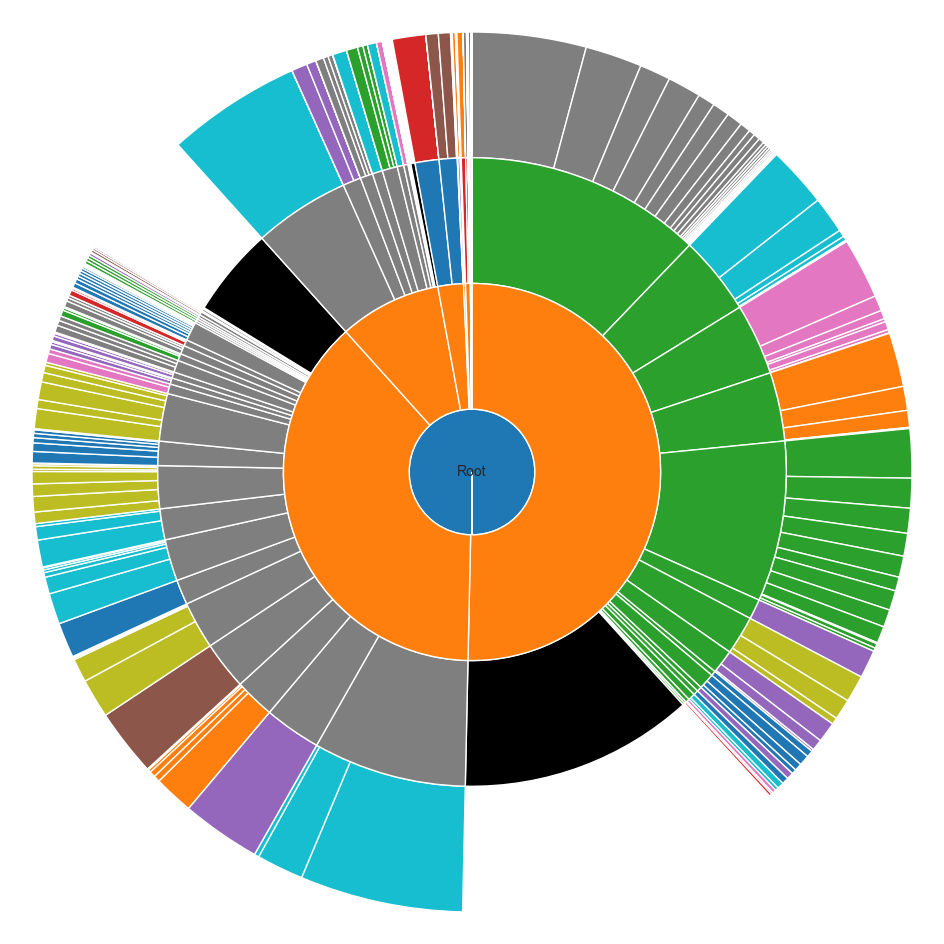

In [28]:
plt.figure(figsize=(12, 12))
sunburst(data_transformed)